# SmolVLM Finetuning on PushT

https://huggingface.co/blog/smolvlm

https://huggingface.co/blog/smolervlm

In [1]:
# !pip install -q accelerate datasets peft bitsandbytes tensorboard
# !pip install wandb

In [2]:
# import os
# os.environ["MAX_JOBS"] = "2"
# !pip install -v flash-attn --no-build-isolation

In [3]:
import os # to deal with files
import gdown # to download from google drive
import zipfile # to unzip
import zarr # to load the dataset
import numpy as np
import torch
from PIL import Image
from torch.utils.data import random_split
from torch.utils.data import Subset
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration
from transformers import TrainingArguments, Trainer
import re
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
import torchvision.transforms as transforms
from peft import PeftModel
from transformers import AutoConfig

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# model_id = "HuggingFaceTB/SmolVLM-256M-Base"
# model_id = "HuggingFaceTB/SmolVLM-500M-Base"
model_id = "HuggingFaceTB/SmolVLM-2.2B-Base"

processor = AutoProcessor.from_pretrained(model_id, size={"longest_edge": int((96/512)*512)})

image_token_id = processor.tokenizer.additional_special_tokens_ids[processor.tokenizer.additional_special_tokens.index("<image>")]

processor.tokenizer.model_max_length = 142

## Loading Data

In [6]:
# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
extracted_dataset_path = "pusht_cchi_v7_replay.zarr"  # Path to extracted dataset

if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# Extract the dataset if it hasn't been extracted yet
if not os.path.isdir(extracted_dataset_path):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dataset_path)

In [7]:
def create_sample_indices(
        episode_ends:np.ndarray, sequence_length:int,
        pad_before: int=0, pad_after: int=0):
    indices = list()
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append([
                buffer_start_idx, buffer_end_idx,
                sample_start_idx, sample_end_idx])
    indices = np.array(indices)
    return indices


def sample_sequence(train_data, sequence_length,
                    buffer_start_idx, buffer_end_idx,
                    sample_start_idx, sample_end_idx):
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[buffer_start_idx:buffer_end_idx]
        data = sample
        if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if sample_start_idx > 0:
                data[:sample_start_idx] = sample[0]
            if sample_end_idx < sequence_length:
                data[sample_end_idx:] = sample[-1]
            data[sample_start_idx:sample_end_idx] = sample
        result[key] = data
    return result

# normalize data
def get_data_stats(data):
    data = data.reshape(-1,data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    # nomalize to [0,1]
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])
    # normalize to [-1, 1]
    ndata = ndata * 2 - 1
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2
    data = ndata * (stats['max'] - stats['min']) + stats['min']
    return data

# dataset
class PushTImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_path: str,
                 pred_horizon: int,
                 obs_horizon: int,
                 action_horizon: int,
                 tokenizer = None):

        # read from zarr dataset
        dataset_root = zarr.open(dataset_path, 'r')

        # float32, [0,1], (N,96,96,3)
        train_image_data = dataset_root['data']['img'][:]
        train_image_data = np.moveaxis(train_image_data, -1,1)
        # (N,3,96,96)

        # (N, D)
        train_data = {
            # first two dims of state vector are agent (i.e. gripper) locations
            'agent_pos': dataset_root['data']['state'][:,:2],
            'action': dataset_root['data']['action'][:]
        }
        episode_ends = dataset_root['meta']['episode_ends'][:]

        # compute start and end of each state-action sequence
        # also handles padding
        indices = create_sample_indices(
            episode_ends=episode_ends,
            sequence_length=pred_horizon,
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1)

        # compute statistics and normalized data to [-1,1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        # images are already normalized
        normalized_train_data['image'] = train_image_data

        self.indices = indices
        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

        # fixed prompt
        self.prompt = "Given the following image: <image> where the green T represents the goal state of the gray T block and the blue dot represents the robot's current position, determine the next [x, y] coordinates the robot should move toward. The goal is to push the gray T block onto the goal state in the same position and orientation as the green indication. Return only the next step."
        self.tokenized_prompt = tokenizer(self.prompt, return_tensors="pt", max_length=128, truncation=True)
        # self.tokenizer = tokenizer

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # get the start/end indices for this datapoint
        buffer_start_idx, buffer_end_idx, \
            sample_start_idx, sample_end_idx = self.indices[idx]

        # get normalized data using these indices
        nsample = sample_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx
        )

        # discard unused observations
        images_np = nsample['image'][:self.obs_horizon, :]  # Shape (obs_horizon, 3, 96, 96)
        pil_images = []
        for image_np in images_np:
            image_np_hwc = image_np.transpose(1, 2, 0)
            image_pil = Image.fromarray((image_np_hwc * 255).astype(np.uint8))
            if image_pil.mode != 'RGB':
                image_pil = image_pil.convert('RGB')
            pil_images.append(image_pil)
        nsample['image'] = pil_images


        nsample['agent_pos'] = nsample['agent_pos'][:self.obs_horizon,:]

        # adds fixed prompt to every example (If using variable prompts, move tokenization to collate_fn!)
        nsample['text'] = self.prompt
        # nsample['text'] = self.tokenized_prompt["input_ids"].squeeze(0)

        # tokenized_prompt = self.tokenizer(self.prompt, return_tensors="pt", max_length=128, truncation=True)
        # nsample['attn_mask'] = self.tokenized_prompt["attention_mask"].squeeze(0)

        return nsample

In [8]:
def collate_fn(examples):
    images = []
    texts = []
    actions = []

    for example in examples:
        image = example["image"]
        images.append(image)

        text = example["text"]
        texts.append(text)

        action = example["action"]
        actions.append(torch.tensor(action, dtype=torch.float16))

    # Process images and texts using the processor
    batch = processor(images=images, text=texts, return_tensors="pt")
    
    # input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    # batch["input_ids"] = input_ids
    
    # batch["attention_mask"] = (input_ids != processor.tokenizer.pad_token_id).long()

    # The target labels are the actions
    batch["labels"] = torch.stack(actions)

    return batch

In [9]:
# parameters
random_split_data  = True
obs_horizon = 1
action_horizon = 0
pred_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTImageDataset(
    dataset_path=extracted_dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon,
    tokenizer = processor.tokenizer
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

if random_split_data:
  train_size = int(0.8 * len(dataset))
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
else:
  train_dataset = Subset(dataset, range(int(0.8 * len(dataset))))
  val_dataset = Subset(dataset, range(int(0.8 * len(dataset)), len(dataset)))

In [10]:
vis_batch = True

if vis_batch:
    batch_size = 2
    # create dataloader
    dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        collate_fn=collate_fn,
        # num_workers=1,
        # persistent_workers=True
    )

    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        collate_fn=collate_fn,
        # num_workers=1,
        # persistent_workers=True
    )

    # visualize data in batch
    batch = next(iter(dataloader))
    print(type(batch), type(batch['pixel_values']), type(batch['input_ids']), type(batch['labels']), type(batch['attention_mask']))
    print("batch['pixel_values'].shape:", batch['pixel_values'].shape)
    print("batch['input_ids'].shape", batch['input_ids'].shape)
    print("batch['labels'].shape", batch['labels'].shape)
    print("batch['attention_mask'].shape", batch['attention_mask'].shape)
    # print("batch['agent_pos'].shape:", batch['agent_pos'].shape)

<class 'transformers.feature_extraction_utils.BatchFeature'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
batch['pixel_values'].shape: torch.Size([2, 1, 3, 512, 512])
batch['input_ids'].shape torch.Size([2, 142])
batch['labels'].shape torch.Size([2, 8, 2])
batch['attention_mask'].shape torch.Size([2, 142])


In [11]:
processor.tokenizer.batch_decode(batch['input_ids'])

["Given the following image: <fake_token_around_image><global-img><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><fake_token_around_image> where the green T represents the goal state of the gray T block and the blue dot represents the robot's current position, determine the next [x, y] coordinates the robot should move toward. The goal is to push the gray T block onto the goal state in the same position and orientation as the green indication. Return only the next step.",
 "Given the following image: <fake_token_around_image><global-img><image><image><image><image><image><image><image><image>

## Loading Model

In [12]:
class PushTModel(torch.nn.Module):
    def __init__(self, base_model, pred_horizon=1):
        super().__init__()
        self.base_model = base_model
        self.pred_horizon = pred_horizon
        hidden_size = base_model.lm_head.in_features

        self.action_head = torch.nn.Linear(hidden_size, pred_horizon*2)

    def forward(self, pixel_values=None, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Forward through the base model (VLM)
        outputs = self.base_model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            # **kwargs
            output_hidden_states=True,
            return_dict=True,
        )

        # summary = outputs.last_hidden_state[:, 0, :]  # [CLS] token basically (batch_size, hidden_size)
        summary = outputs.hidden_states[-1][:, 0, :]

        flat_preds = self.action_head(summary) # (batch_size, pred_horizon * 2)

        action_preds = flat_preds.view(-1, self.pred_horizon, 2) # (batch_size, pred_horizon, 2)

        loss = None
        if labels is not None:
            loss = self.custom_loss(action_preds, labels)

        return {"loss": loss, "logits": action_preds}

    def custom_loss(self, predictions, targets):
        loss_fct = torch.nn.MSELoss()
        return loss_fct(predictions, targets)
    
    def gradient_checkpointing_enable(self, **kwargs):
        return self.base_model.gradient_checkpointing_enable(**kwargs)

In [13]:
USE_LORA = False
USE_QLORA = True

if USE_QLORA:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    # _attn_implementation="flash_attention_2",
    device_map="auto"
)


# Identify names of layers for LoRA finetuning (in vision model only b/c of constant prompt)
target_modules = set()

vision_suffixes = {'k_proj','q_proj','v_proj','fc1', 'fc2', }
for name, _ in model.named_modules():
    if "vision_model." in name:
        if any(name.endswith(suffix) for suffix in vision_suffixes):
            target_modules.add(name)

In [14]:
lora = True
lora_alpha = 8 # affects contribution of LoRA updates
lora_rank = 8 # how much the LoRA layers compress the full-rank weight updates

if USE_QLORA or USE_LORA:
  lora_config = LoraConfig(
      r = lora_rank,
      lora_alpha = lora_alpha,
      lora_dropout = 0.1, # regularization
      target_modules= target_modules,
      use_dora=False if USE_QLORA else True,
      init_lora_weights="gaussian",
    #   bias = "none",
    #   task_type="CAUSAL_LM",
  )
lora_config.inference_mode = False


# model.add_adapter(lora_config)
# model.enable_adapters()
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

model = PushTModel(model, pred_horizon=pred_horizon)


model.base_model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 508,661,952 || trainable%: 0.2319


## Training

In [15]:
model_name = model_id.split("/")[-1]

from datetime import datetime
now = datetime.now().strftime("%Y%m%d_%H%M%S")

run_name = f"{model_name}_{now}"
print(run_name)

import wandb
wandb.login()

SmolVLM-500M-Base_20250426_140312


wandb: Currently logged in as: florianfrick (florianfrick-university-of-colorado-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [16]:
training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    optim="paged_adamw_8bit" if USE_QLORA else "adamw_hf",
    bf16=True, # underlying precision for 8bit
    output_dir=f"./{run_name}",
    # hub_model_id=f"{model_name}-pusht",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    report_to="wandb",
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [18]:
training = True

if training:
    wandb.init(project="pusht", name=run_name)
    trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
25,1.081300
50,0.661400
75,0.694600
100,0.720300
125,0.683500
150,0.687300
175,0.670800
200,0.648300
225,0.652500
250,0.645900


In [19]:
model

PushTModel(
  (base_model): PeftModel(
    (base_model): LoraModel(
      (model): Idefics3ForConditionalGeneration(
        (model): Idefics3Model(
          (vision_model): Idefics3VisionTransformer(
            (embeddings): Idefics3VisionEmbeddings(
              (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
              (position_embedding): Embedding(1024, 768)
            )
            (encoder): Idefics3Encoder(
              (layers): ModuleList(
                (0-11): 12 x Idefics3EncoderLayer(
                  (self_attn): Idefics3VisionAttention(
                    (k_proj): lora.Linear4bit(
                      (base_layer): Linear4bit(in_features=768, out_features=768, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=768, out_feat

## Inference

In [20]:
from safetensors.torch import load_file

# checkpoint_path = "./SmolVLM-256M-Base_20250425_202015/checkpoint-318"
# checkpoint_path = "./SmolVLM-500M-Base_20250426_004624/checkpoint-3816"

weights = load_file(f"{checkpoint_path}/model.safetensors")
model.load_state_dict(weights, strict=False)

model = model.to(device)

NameError: name 'checkpoint_path' is not defined

In [ ]:
if vis_batch:
    with torch.no_grad():
        outputs = model(
            pixel_values=batch['pixel_values'].to(device),
            input_ids=batch['input_ids'].to(device),
            labels=batch['labels'].to(device),
            attention_mask=batch['attention_mask'].to(device),
        )
    print("outputs:", outputs)

outputs: {'loss': tensor(0.1387, device='cuda:0'), 'logits': tensor([[[-0.1480,  0.0987]],

        [[-0.1480,  0.0987]]], device='cuda:0')}


e:\miniconda\envs\pusht\lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [111.08362418 119.59374661]


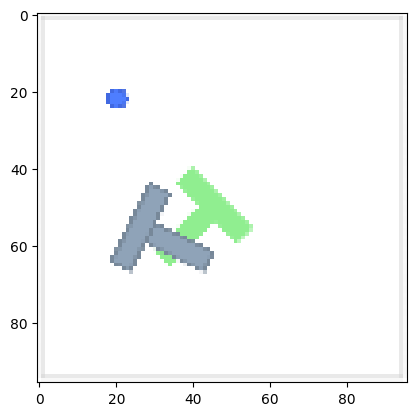

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [163.49514763 194.785243  ]


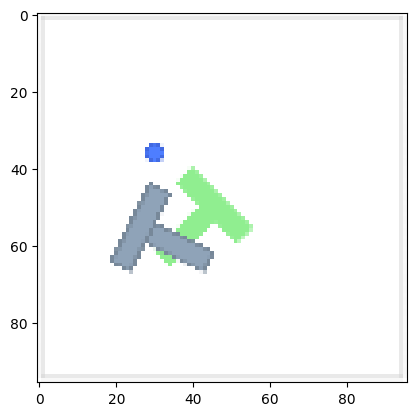

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [194.07093882 239.93003384]


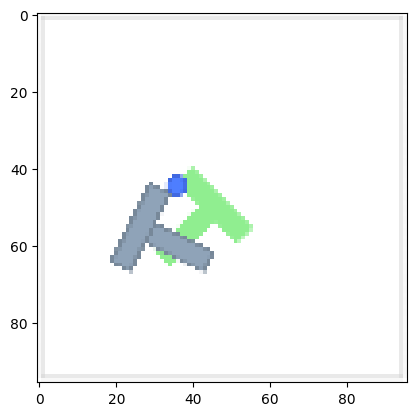

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [210.18422128 262.77753801]


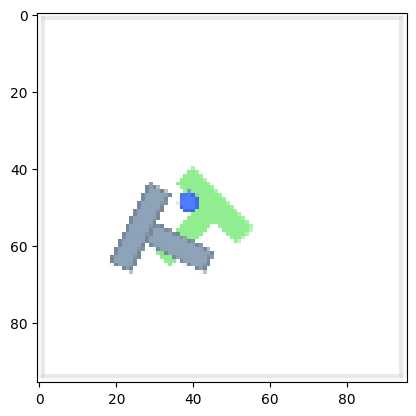

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [217.37187745 274.57718903]


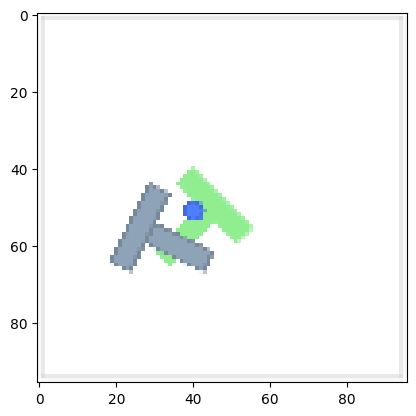

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [219.72669081 281.0234018 ]


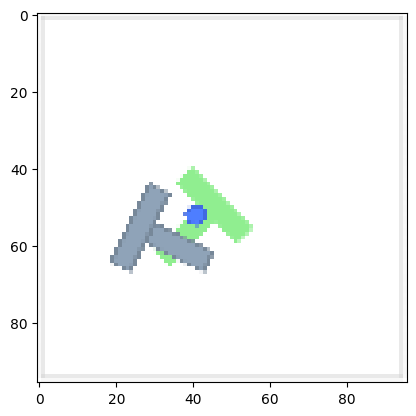

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [221.28569803 283.55526483]


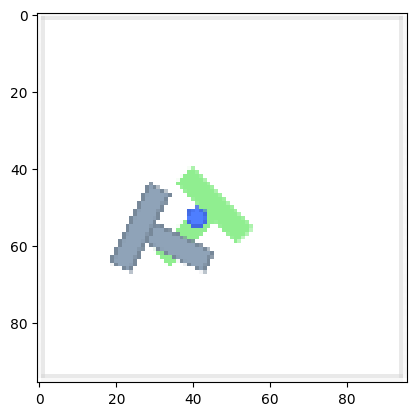

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.71907415 284.90782662]


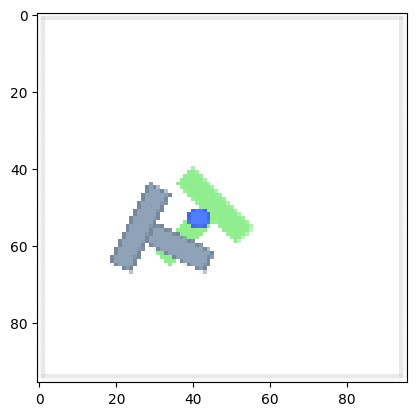

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.03159538 285.40105922]


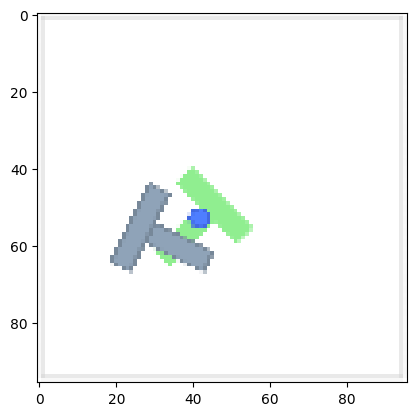

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.74821456 285.25855099]


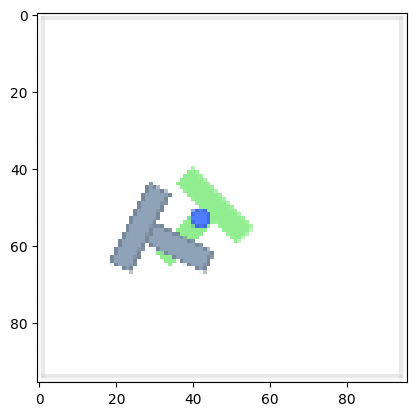

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.27455727 285.2567015 ]


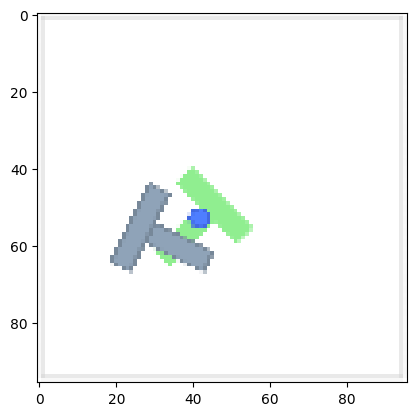

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.2729815  284.69089605]


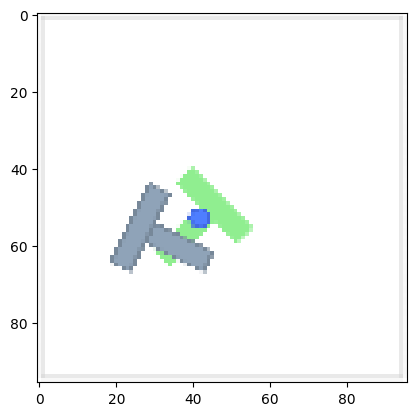

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.54998741 285.00088788]


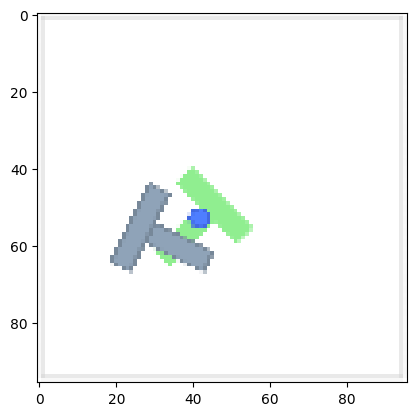

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.11525953 285.94387856]


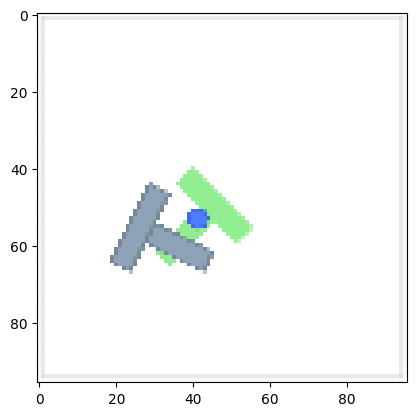

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [222.87941587 285.8694187 ]


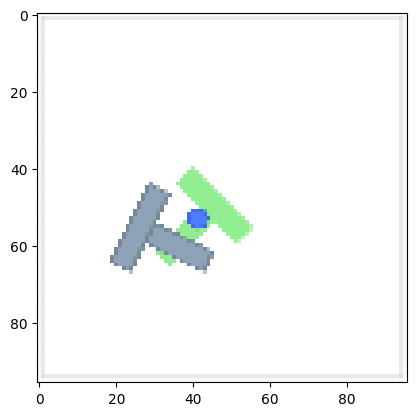

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.46728722 285.99425521]


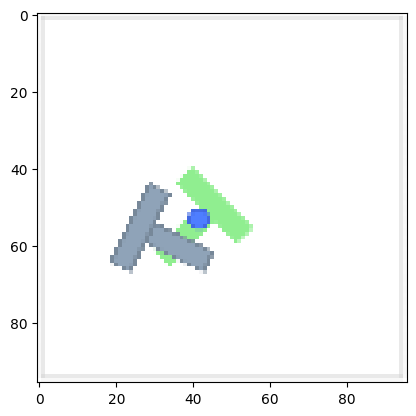

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.38255627 285.9106625 ]


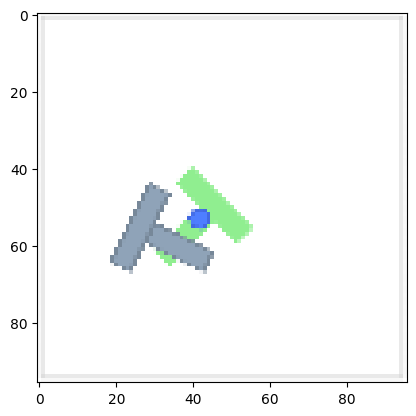

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.91276783 285.49748549]


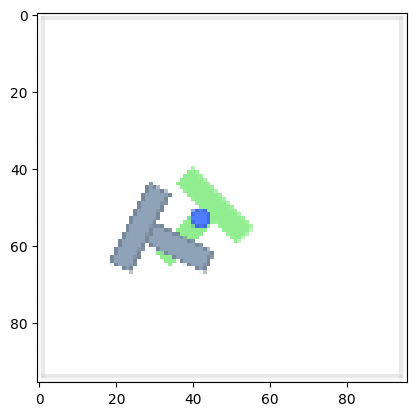

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.35169443 285.368706  ]


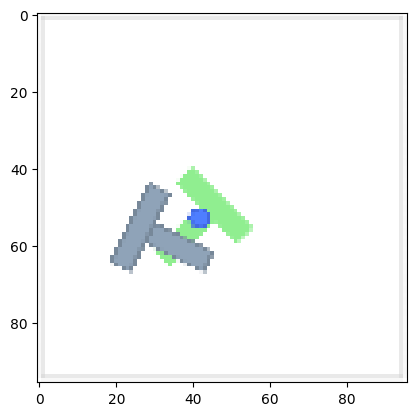

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.30913718 284.74339469]


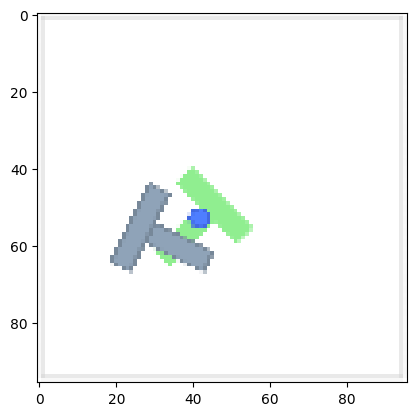

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.56693343 285.02549378]


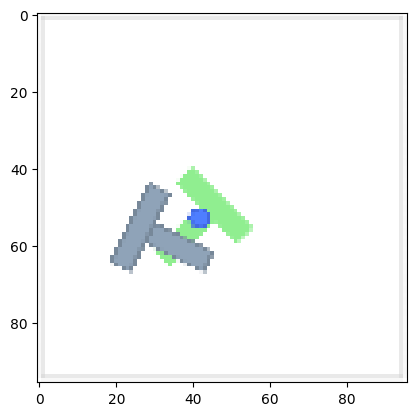

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.12320186 285.95541096]


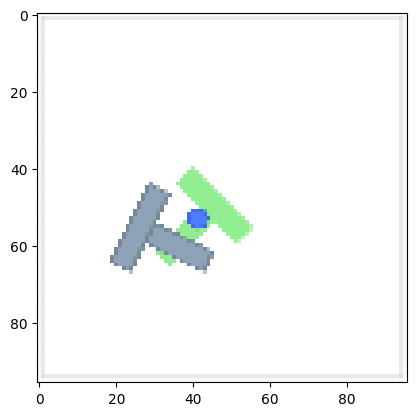

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [222.88313828 285.87482369]


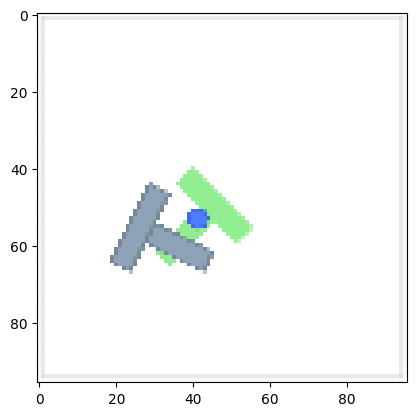

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.46903182 285.9967884 ]


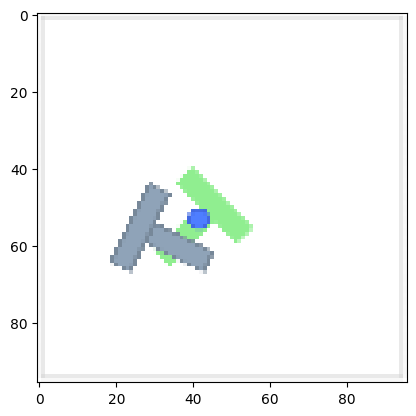

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.38337392 285.91184975]


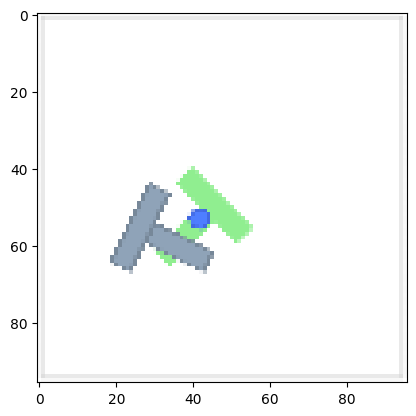

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.91315104 285.49804192]


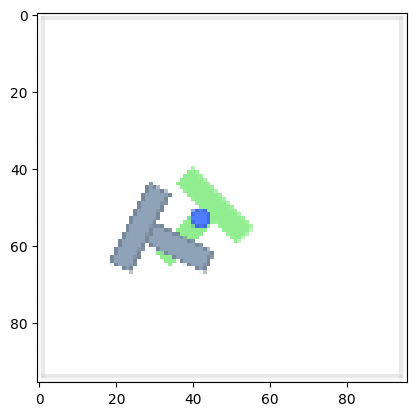

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.35187404 285.36896678]


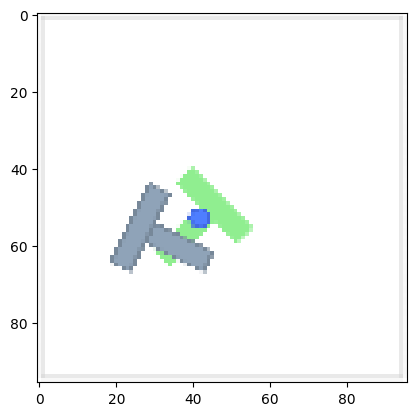

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.30922136 284.74351691]


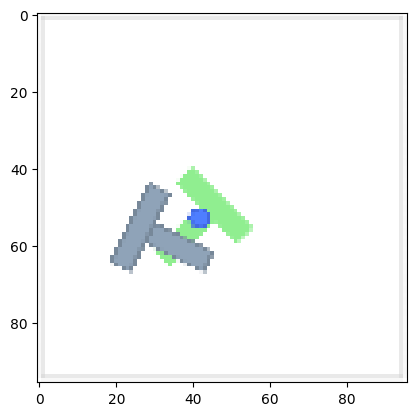

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.56697288 285.02555106]


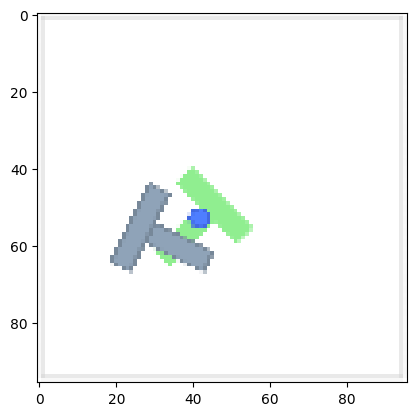

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.12322035 285.95543781]


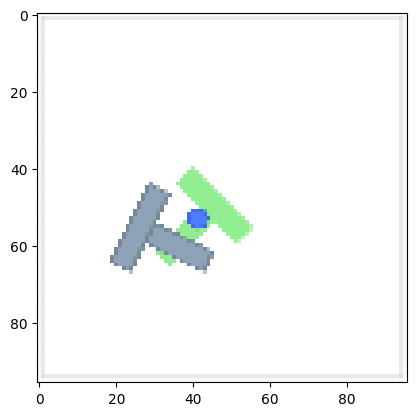

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [222.88314694 285.87483628]


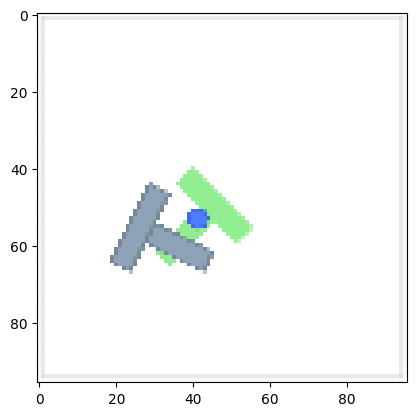

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.46903588 285.9967943 ]


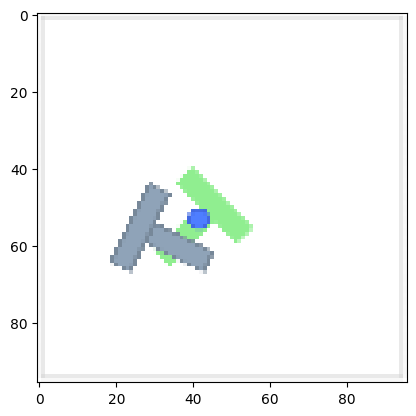

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.38337582 285.91185251]


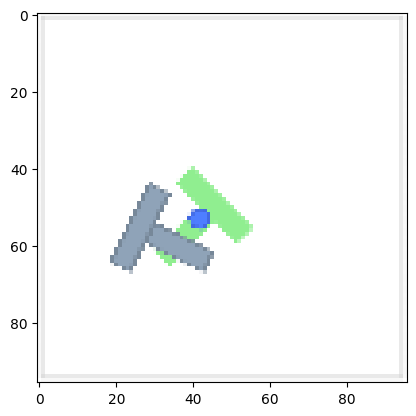

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.91315194 285.49804321]


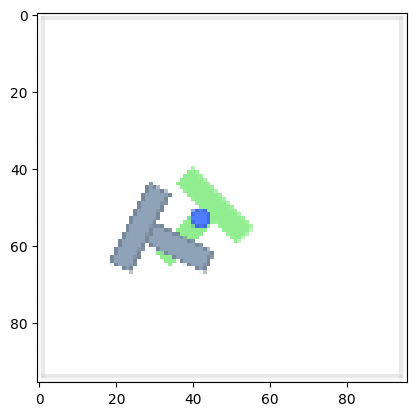

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.35187445 285.36896739]


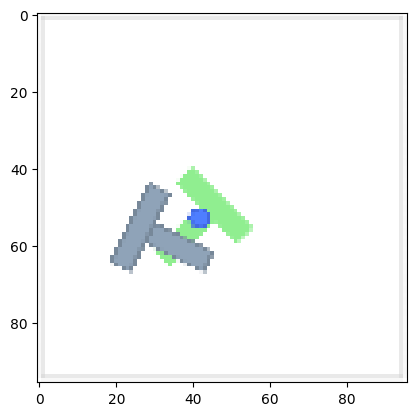

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.30922155 284.74351719]


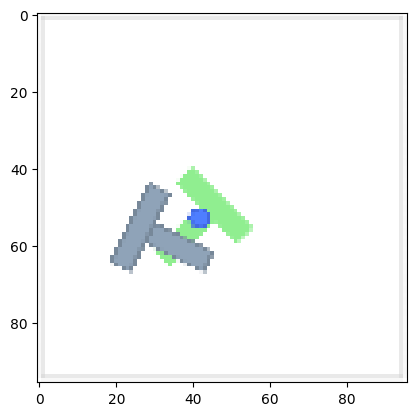

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.56697297 285.02555119]


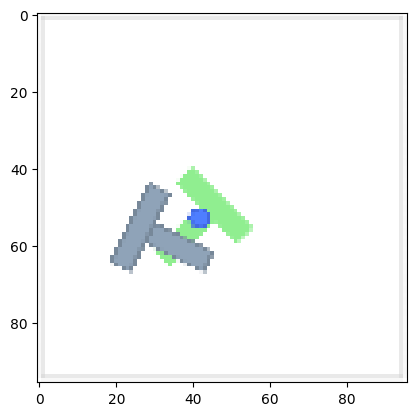

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.1232204  285.95543787]


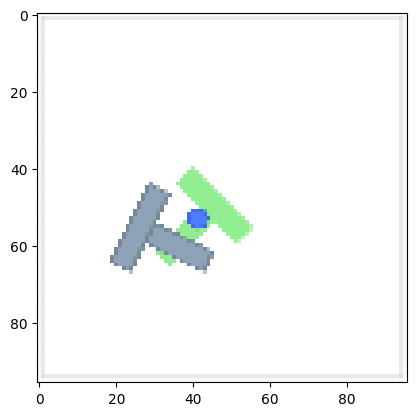

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [222.88314696 285.87483631]


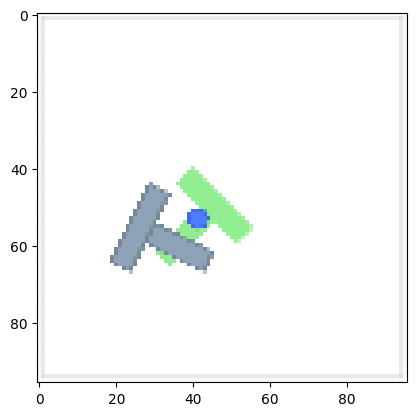

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.46903589 285.99679431]


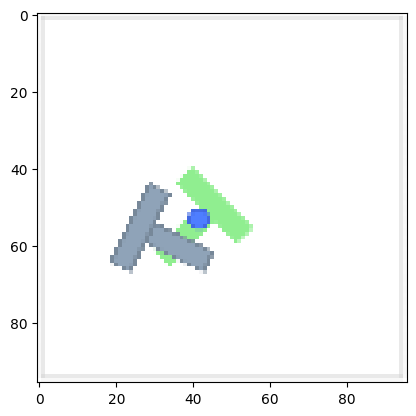

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.38337583 285.91185252]


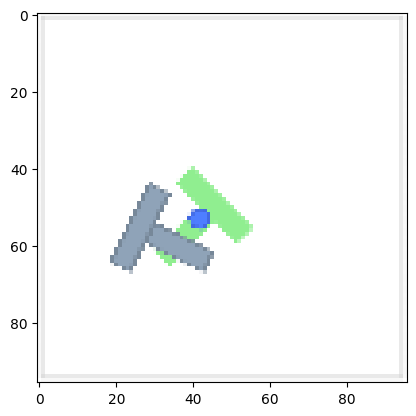

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.91315194 285.49804322]


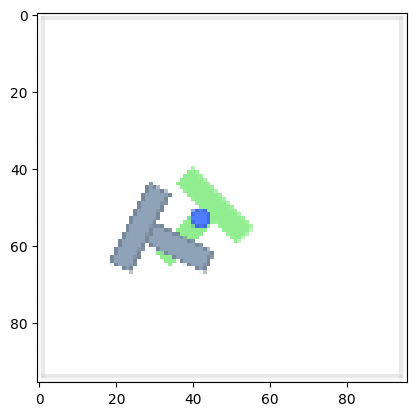

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.35187446 285.36896739]


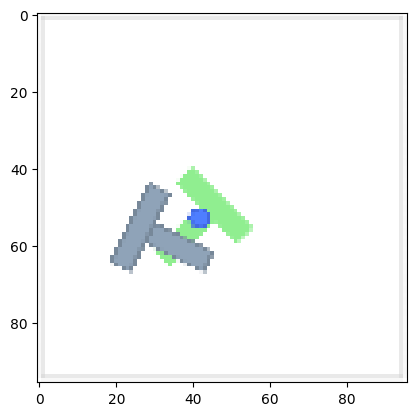

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.30922155 284.7435172 ]


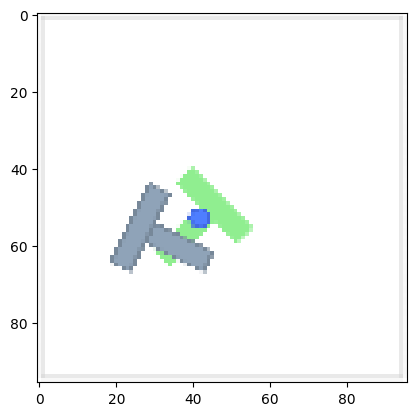

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.56697297 285.02555119]


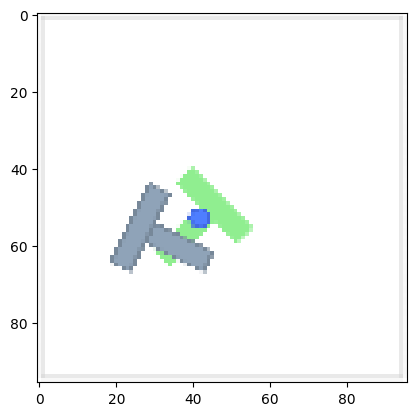

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.1232204  285.95543787]


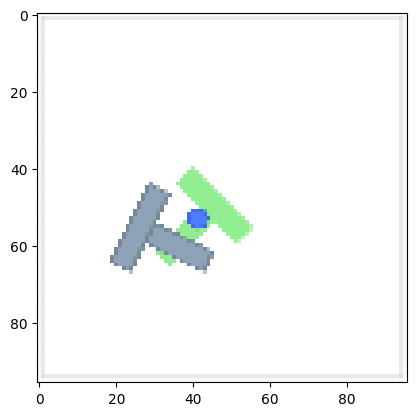

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [222.88314696 285.87483631]


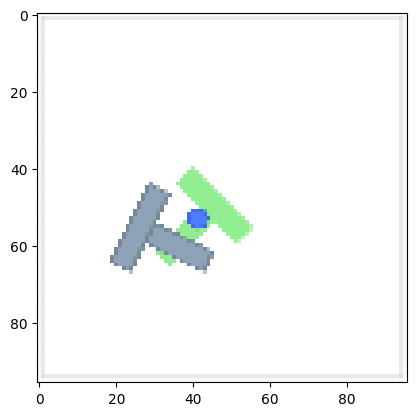

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.46903589 285.99679431]


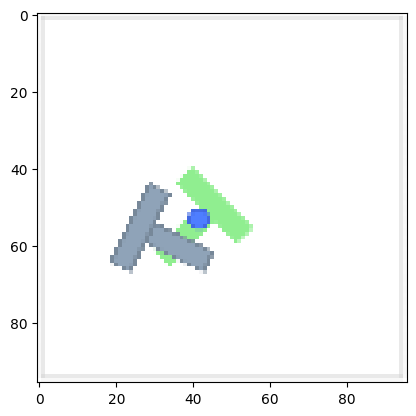

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.38337583 285.91185252]


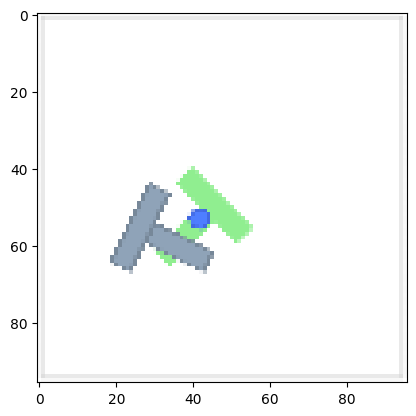

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.91315194 285.49804322]


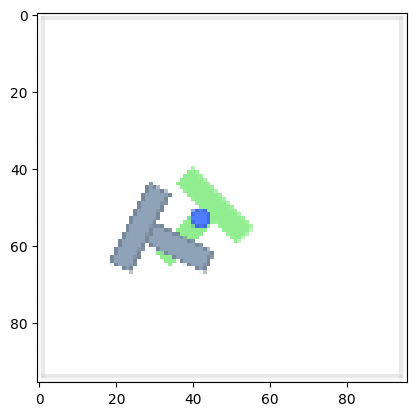

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.35187446 285.36896739]


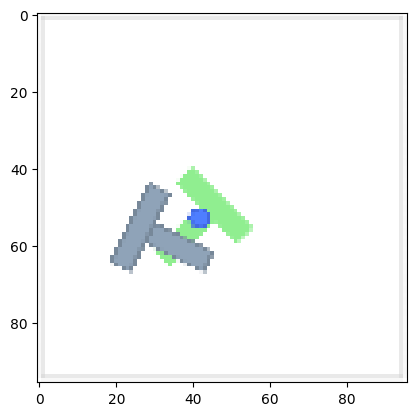

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.30922155 284.7435172 ]


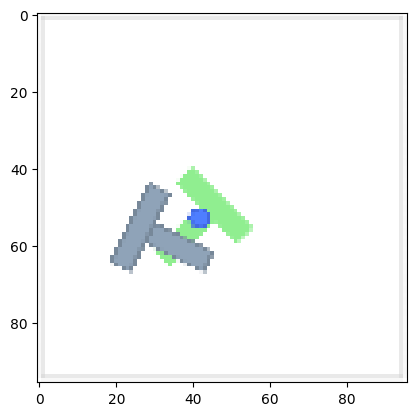

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.56697297 285.02555119]


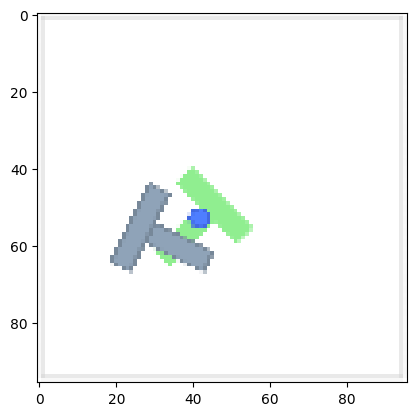

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.1232204  285.95543787]


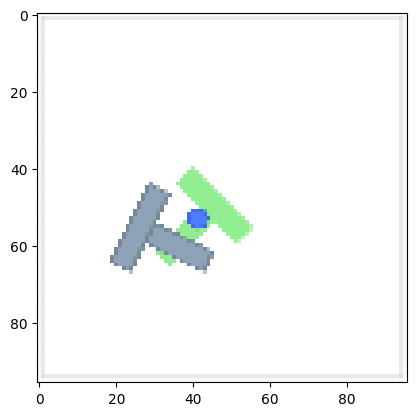

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [222.88314696 285.87483631]


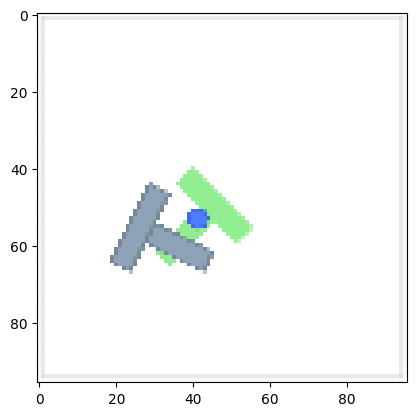

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.46903589 285.99679431]


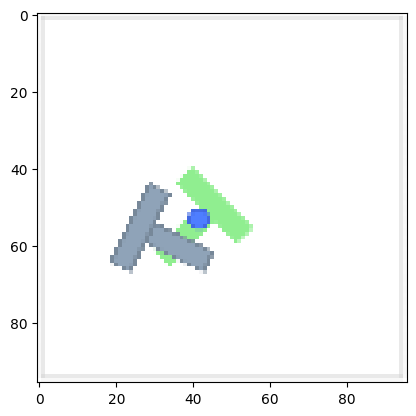

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.38337583 285.91185252]


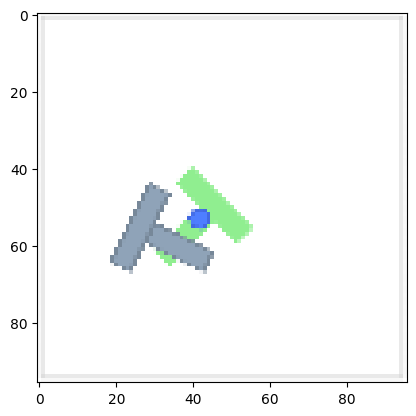

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.91315194 285.49804322]


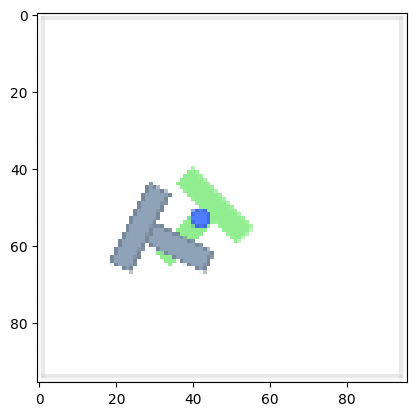

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.35187446 285.36896739]


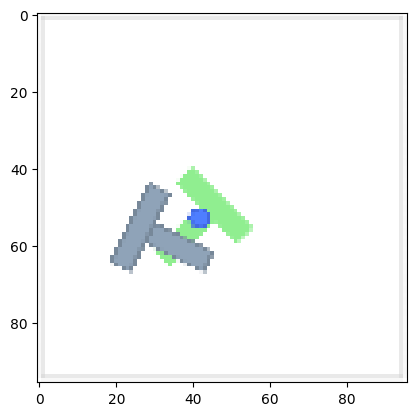

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.30922155 284.7435172 ]


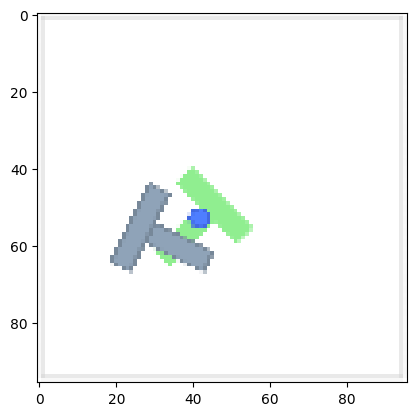

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.56697297 285.02555119]


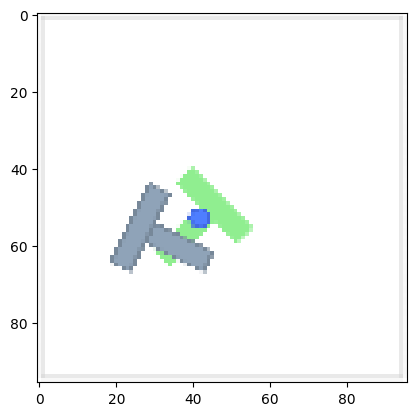

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.1232204  285.95543787]


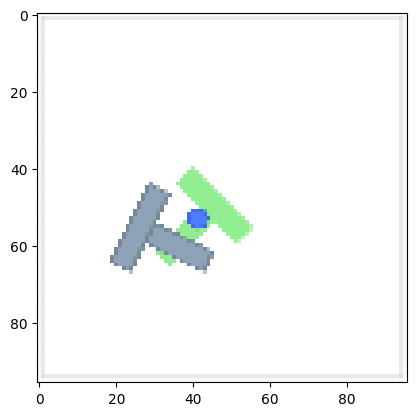

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [222.88314696 285.87483631]


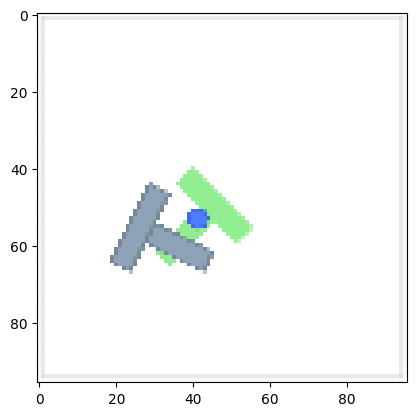

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.46903589 285.99679431]


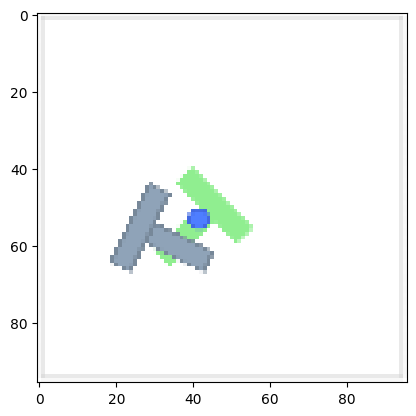

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.38337583 285.91185252]


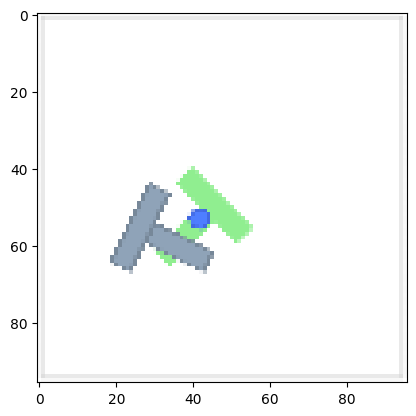

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.91315194 285.49804322]


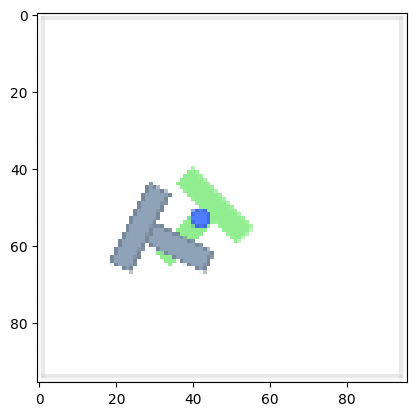

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.35187446 285.36896739]


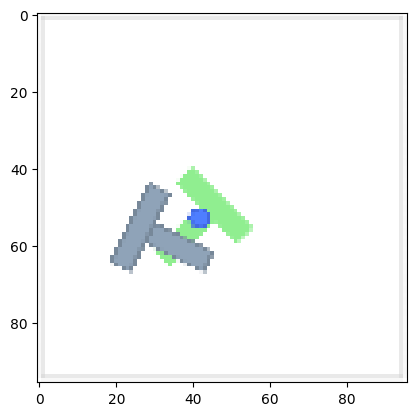

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.30922155 284.7435172 ]


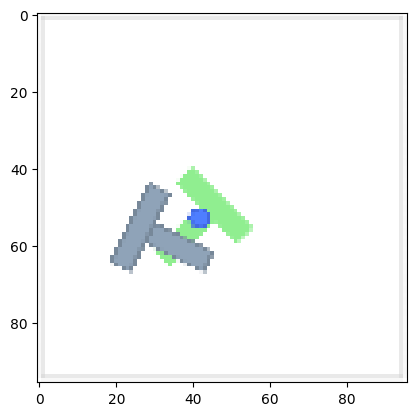

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.56697297 285.02555119]


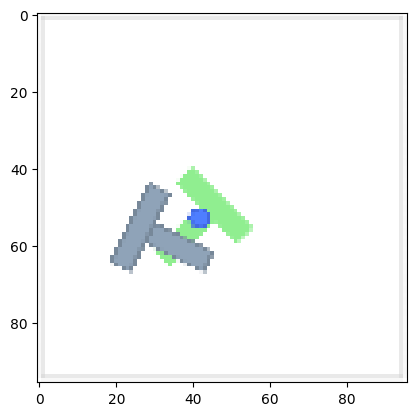

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.1232204  285.95543787]


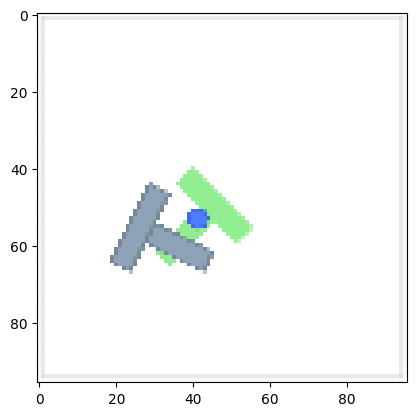

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [222.88314696 285.87483631]


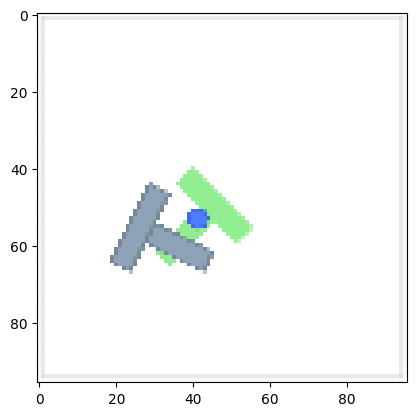

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.46903589 285.99679431]


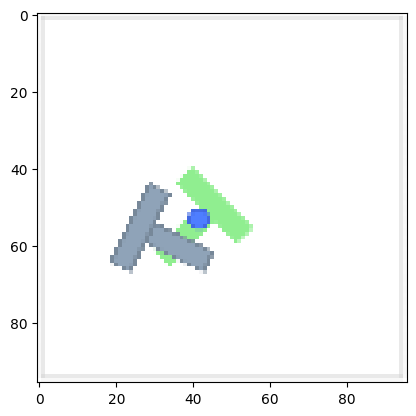

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.38337583 285.91185252]


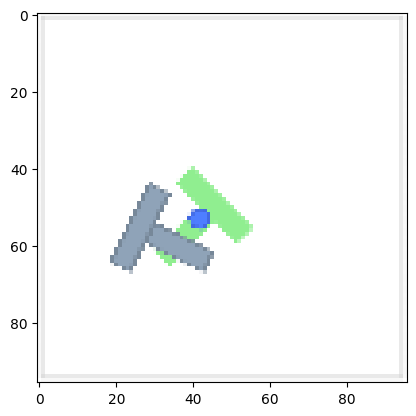

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.91315194 285.49804322]


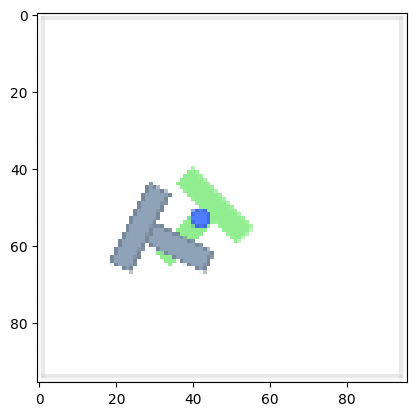

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.35187446 285.36896739]


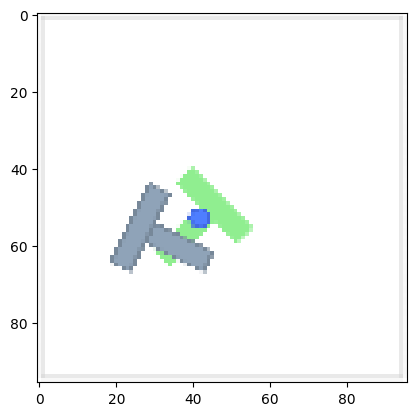

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [225.30922155 284.7435172 ]


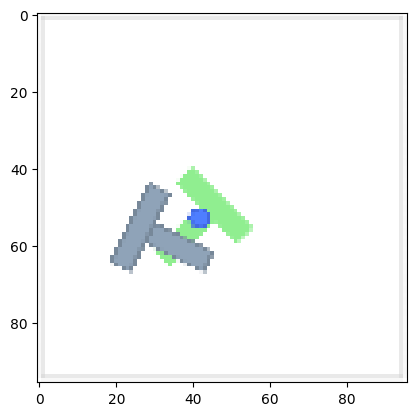

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.56697297 285.02555119]


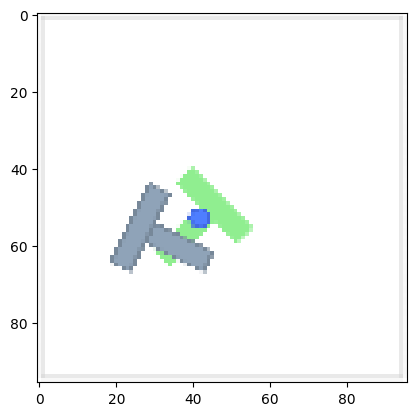

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [223.1232204  285.95543787]


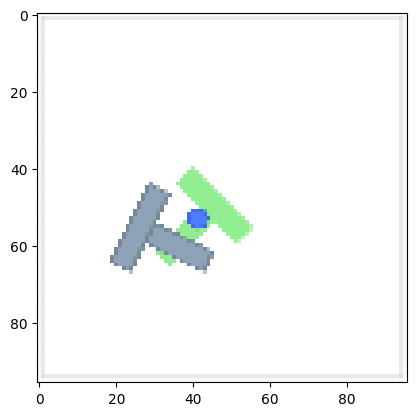

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [222.88314696 285.87483631]


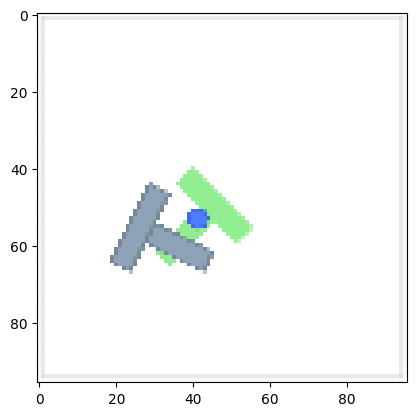

Action: [[225.625 285.375]
 [226.75  284.75 ]
 [223.5   285.5  ]
 [226.125 283.25 ]
 [222.5   286.5  ]
 [220.75  287.5  ]
 [223.75  284.75 ]
 [228.    286.75 ]]
Robot pos: [224.46903589 285.99679431]


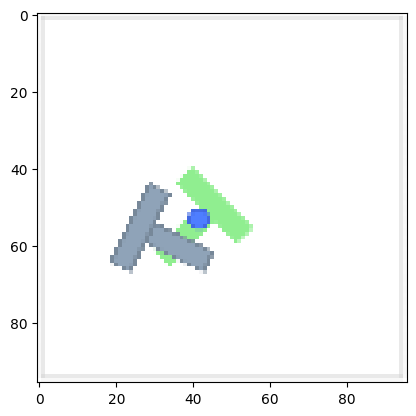

In [27]:
import gymnasium as gym
import gym_pusht

prompt = ("Given the following image: <image> where the green T represents the goal state of the gray T block "
          "and the blue dot represents the robot's current position, determine the next [x, y] coordinates "
          "the robot should move toward. The goal is to push the gray T block onto the goal state in the same "
          "position and orientation as the green indication. Return only the next step.")

visualization_width=96
visualization_height=96
observation_width=96
observation_height=96

env = gym.make("gym_pusht/PushT-v0", obs_type="pixels_agent_pos",
               visualization_width=visualization_width,
               visualization_height=visualization_height,
               observation_width=observation_width,
               observation_height=observation_height
              )
observation, info = env.reset()
# print("act space",env.action_space)

sx = observation_width / visualization_width
sy = observation_height / visualization_height

for _ in range(10):
    inputs = processor(images=observation['pixels'], text=prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    predicted_xy = outputs['logits'].squeeze().cpu().numpy()

    # shift from [-1,1] to [0,512]
    action = predicted_xy.astype(np.float32)
    action = (predicted_xy + 1.0) * 0.5 * (env.action_space.high - env.action_space.low)
    
    for a in action:
        observation, reward, terminated, truncated, info = env.step(a)
        
        print("Action:",action)
        print("Robot pos:", observation['agent_pos'])
        plt.imshow(observation['pixels'])
        # plt.scatter(action[0]*sx, sy*action[1], color='red')
        # plt.scatter(observation['agent_pos'][0]*sx, sy*observation['agent_pos'][1], color='blue')
        plt.show()

        if terminated or truncated:
            observation, info = env.reset()

env.close()

In [36]:
model.action_head.weight

Parameter containing:
tensor([[-0.0028,  0.0105,  0.0271,  ..., -0.0310, -0.0084, -0.0208],
        [ 0.0092,  0.0150,  0.0268,  ..., -0.0089,  0.0130,  0.0039],
        [-0.0109, -0.0101,  0.0291,  ..., -0.0065,  0.0167, -0.0260],
        ...,
        [ 0.0051,  0.0043,  0.0052,  ..., -0.0272, -0.0055,  0.0205],
        [-0.0223,  0.0247,  0.0109,  ...,  0.0131, -0.0274, -0.0021],
        [-0.0092, -0.0081, -0.0268,  ..., -0.0239,  0.0203, -0.0246]],
       device='cuda:0', requires_grad=True)